<a href="https://colab.research.google.com/github/kuzmatsukanov/kuzma_omri_noa_data_project/blob/noa/image_identification_noa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from multiprocessing import Pool
from functools import partial


from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint

For multiprocessing later on:

In [ ]:
img_size = 80

In [ ]:
def load_image(image_path, resize_shape=None):
    img = cv2.imread(image_path)
    if resize_shape is not None:
        img = cv2.resize(img, resize_shape)
    return img

def load_images_parallel(image_paths, n_jobs=4, resize_shape=None):
    with Pool(processes=n_jobs) as pool:
        func = partial(load_image, resize_shape=resize_shape)
        images = pool.map(func, image_paths)
    return np.array(images)

Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

shared_folder_path = '/content/drive/MyDrive/ds_project_dataset'

!cp -r "$shared_folder_path" .

Mounted at /content/drive


Dataframe

In [ ]:
df = pd.read_csv('ds_project_dataset/articles.csv')

In [ ]:
df.sample(5)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
82805,809989002,809989,Kim top,258,Blouse,Garment Upper body,1010016,Solid,51,Light Pink,...,Baby Girl Woven,G,Baby Sizes 50-98,4,Baby/Children,40,Baby Girl,1006,Woven/Jersey/Knitted mix Baby,Blouse in a soft cotton weave with an elastica...
68631,754877005,754877,Bagira Padded Soft Bra Mia,306,Bra,Underwear,1010016,Solid,51,Light Pink,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Soft, non-wired bra in lace and mesh with remo..."
61939,734700004,734700,Magnolia Trench,263,Coat,Garment Upper body,1010016,Solid,14,Dark Beige,...,Outwear,A,Ladieswear,1,Ladieswear,19,Womens Jackets,1007,Outdoor,Lightweight trenchcoat in twill made from a cu...
24304,608922001,608922,Joel mixed low SB,94,Sneakers,Shoes,1010016,Solid,10,White,...,Kids Boy Shoes,J,"Children Accessories, Swimwear",4,Baby/Children,42,Kids & Baby Shoes,1020,Shoes,Canvas trainers with contrasting colour detail...
29012,624525001,624525,Tinna sneaker,94,Sneakers,Shoes,1010001,All over pattern,81,Light Turquoise,...,Baby Shoes,G,Baby Sizes 50-98,4,Baby/Children,42,Kids & Baby Shoes,1020,Shoes,Trainers with elasticated lacing at the front ...


In [ ]:
df.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [ ]:
df['product_group_name'].unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Accessories', 'Items', 'Nightwear',
       'Unknown', 'Underwear/nightwear', 'Shoes', 'Swimwear',
       'Garment Full body', 'Cosmetic', 'Interior textile', 'Bags',
       'Furniture', 'Garment and Shoe care', 'Fun', 'Stationery'],
      dtype=object)

In [ ]:
df['perceived_colour_master_name'].unique()

array(['Black', 'White', 'Beige', 'Grey', 'Blue', 'Pink', 'Lilac Purple',
       'Red', 'Mole', 'Orange', 'Metal', 'Brown', 'Turquoise', 'Yellow',
       'Khaki green', 'Green', 'undefined', 'Unknown', 'Yellowish Green',
       'Bluish Green'], dtype=object)

In [ ]:
df['graphical_appearance_name'].unique()

array(['Solid', 'Stripe', 'All over pattern', 'Melange', 'Transparent',
       'Metallic', 'Application/3D', 'Denim', 'Colour blocking', 'Dot',
       'Other structure', 'Contrast', 'Treatment', 'Check', 'Chambray',
       'Front print', 'Glittering/Metallic', 'Mixed solid/pattern',
       'Placement print', 'Other pattern', 'Neps', 'Embroidery', 'Lace',
       'Jacquard', 'Unknown', 'Argyle', 'Slub', 'Mesh', 'Sequin',
       'Hologram'], dtype=object)

In [ ]:
df['index_group_name'].unique()

array(['Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'],
      dtype=object)

Relevant categories

In [ ]:
selected_categories = ['Garment Upper body', 'Underwear', 'Socks & Tights', 'Garment Lower body', 'Shoes', 'Garment Full body', 'Bags']
df = df[df['product_group_name'].isin(selected_categories)]

In [ ]:
df['product_group_name'].unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Shoes', 'Garment Full body', 'Bags'],
      dtype=object)

In [ ]:
selected_categories = ['undefined', 'Unknown']
df = df[~df['perceived_colour_master_name'].isin(selected_categories)]

In [ ]:
df['perceived_colour_master_name'] = df['perceived_colour_master_name'].replace(['Khaki green', 'Yellowish Green', 'Bluish Green', 'Lilac Purple'], ['Green', 'Green', 'Green', 'Purple'])

In [ ]:
df['perceived_colour_master_name'].unique()

array(['Black', 'White', 'Beige', 'Grey', 'Blue', 'Pink', 'Purple', 'Red',
       'Brown', 'Green', 'Yellow', 'Orange', 'Turquoise', 'Mole', 'Metal'],
      dtype=object)

In [ ]:
selected_categories = ['Other pattern', 'Unknown', 'Other structure']
df = df[~df['graphical_appearance_name'].isin(selected_categories)]

In [ ]:
df['graphical_appearance_name'].unique()

array(['Solid', 'Stripe', 'All over pattern', 'Melange', 'Denim',
       'Colour blocking', 'Dot', 'Contrast', 'Treatment', 'Check',
       'Mixed solid/pattern', 'Placement print', 'Glittering/Metallic',
       'Neps', 'Embroidery', 'Application/3D', 'Chambray', 'Lace',
       'Front print', 'Transparent', 'Jacquard', 'Argyle', 'Slub',
       'Metallic', 'Mesh', 'Sequin', 'Hologram'], dtype=object)

In [ ]:
selected_categories = ['Ladieswear', 'Menswear', 'Divided']
df = df[df['index_group_name'].isin(selected_categories)]

In [ ]:
df.shape

(54933, 25)

Baseline

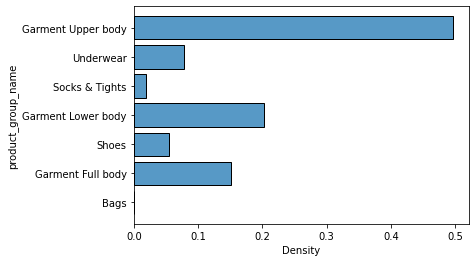

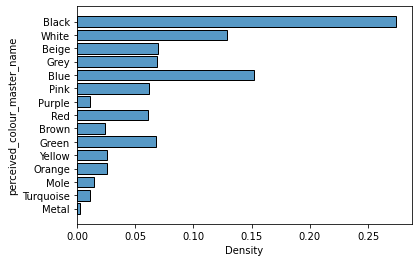

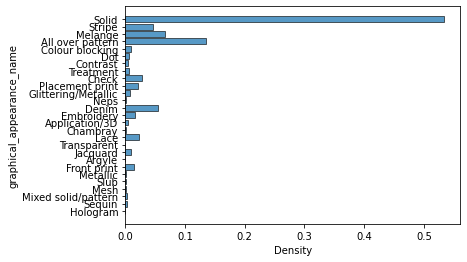

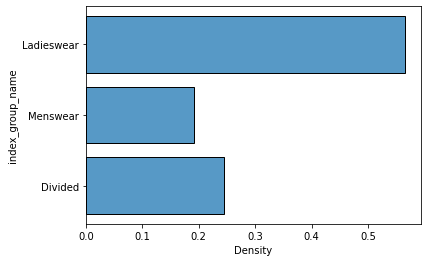

In [ ]:
for feat in ['product_group_name', 'perceived_colour_master_name', 'graphical_appearance_name', 'index_group_name']:
  sns.histplot(y=df[feat], stat = 'density', shrink = 0.8, common_norm=False)
  plt.show()

In [ ]:
df['subfolder'] = '0' + df['article_id'].astype(str).str[:2]
df['image_path'] = 'ds_project_dataset/images/' + df['subfolder'].str.strip() + '/0' + df['article_id'].astype(str) + '.jpg'

In [ ]:
df['image_path']

0         ds_project_dataset/images/010/0108775015.jpg
1         ds_project_dataset/images/010/0108775044.jpg
2         ds_project_dataset/images/010/0108775051.jpg
3         ds_project_dataset/images/011/0110065001.jpg
4         ds_project_dataset/images/011/0110065002.jpg
                              ...                     
105536    ds_project_dataset/images/095/0952938001.jpg
105537    ds_project_dataset/images/095/0953450001.jpg
105538    ds_project_dataset/images/095/0953763001.jpg
105539    ds_project_dataset/images/095/0956217002.jpg
105541    ds_project_dataset/images/095/0959461001.jpg
Name: image_path, Length: 54933, dtype: object

In [ ]:
df['image_path'][0]

'ds_project_dataset/images/010/0108775015.jpg'

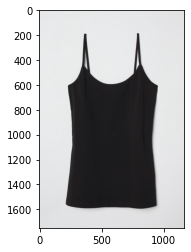

In [ ]:
img = cv2.imread(df['image_path'][0])
plt.imshow(img)
plt.show()

In [ ]:
import os

valid_images = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    if os.path.isfile(row['image_path']):
        valid_images.append(row)

df_valid_images = pd.DataFrame(valid_images)

100%|██████████| 54933/54933 [09:33<00:00, 95.81it/s] 


In [ ]:
df_valid_images.shape

(44388, 27)

In [ ]:
images = load_images_parallel(df_valid_images['image_path'].values, n_jobs=4, resize_shape=(img_size, img_size))

Encoding for the model

In [ ]:
new_df = pd.DataFrame(df_valid_images['article_id'])

In [ ]:
new_df

,article_id
0,108775015
1,108775044
2,108775051
3,110065001
4,110065002
...,...
87117,826164005
87118,826164006
87119,826164007
87120,826164009


In [ ]:
new_df = new_df.join(pd.get_dummies(df_valid_images['perceived_colour_master_name'], prefix='colour'))
new_df = new_df.join(pd.get_dummies(df_valid_images['product_group_name'], prefix='product'))
new_df = new_df.join(pd.get_dummies(df_valid_images['graphical_appearance_name'], prefix='pattern'))
new_df = new_df.join(pd.get_dummies(df_valid_images['index_group_name'], prefix='index'))

In [ ]:
new_df.sample(5)

,article_id,colour_Beige,colour_Black,colour_Blue,colour_Brown,colour_Green,colour_Grey,colour_Metal,colour_Mole,colour_Orange,...,pattern_Placement print,pattern_Sequin,pattern_Slub,pattern_Solid,pattern_Stripe,pattern_Transparent,pattern_Treatment,index_Divided,index_Ladieswear,index_Menswear
4038,474461031,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
62533,736632004,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
79664,798645001,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
67069,749699032,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
79260,796987001,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
color_array = new_df.filter(like='colour_').to_numpy()
pattern_array = new_df.filter(like='pattern_').to_numpy()
type_array = new_df.filter(like='product_').to_numpy()
index_array = new_df.filter(like='index_').to_numpy()

In [ ]:
new_df.filter(like='colour_').columns

Index(['colour_Beige', 'colour_Black', 'colour_Blue', 'colour_Brown',
       'colour_Green', 'colour_Grey', 'colour_Metal', 'colour_Mole',
       'colour_Orange', 'colour_Pink', 'colour_Purple', 'colour_Red',
       'colour_Turquoise', 'colour_White', 'colour_Yellow'],
      dtype='object')

In [ ]:
new_df.filter(like='pattern_').columns

Index(['pattern_All over pattern', 'pattern_Application/3D', 'pattern_Argyle',
       'pattern_Chambray', 'pattern_Check', 'pattern_Colour blocking',
       'pattern_Contrast', 'pattern_Denim', 'pattern_Dot',
       'pattern_Embroidery', 'pattern_Front print',
       'pattern_Glittering/Metallic', 'pattern_Hologram', 'pattern_Jacquard',
       'pattern_Lace', 'pattern_Melange', 'pattern_Mesh', 'pattern_Metallic',
       'pattern_Mixed solid/pattern', 'pattern_Neps',
       'pattern_Placement print', 'pattern_Sequin', 'pattern_Slub',
       'pattern_Solid', 'pattern_Stripe', 'pattern_Transparent',
       'pattern_Treatment'],
      dtype='object')

In [ ]:
new_df.filter(like='product_').columns

Index(['product_Bags', 'product_Garment Full body',
       'product_Garment Lower body', 'product_Garment Upper body',
       'product_Shoes', 'product_Socks & Tights', 'product_Underwear'],
      dtype='object')

In [ ]:
new_df.filter(like='index_').columns

Index(['index_Divided', 'index_Ladieswear', 'index_Menswear'], dtype='object')

In [ ]:
color_array

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

Splitting + Model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_color_train, y_color_test, y_type_train, y_type_test, y_pattern_train, y_pattern_test, y_index_train, y_index_test = train_test_split(
    images, color_array, type_array, pattern_array, index_array, test_size=0.2, random_state=42)

X_train, X_val, y_color_train, y_color_val, y_type_train, y_type_val, y_pattern_train, y_pattern_val, y_index_train, y_index_val = train_test_split(
    X_train, y_color_train, y_type_train, y_pattern_train, y_index_train, test_size=0.25, random_state=42)


In [ ]:
inputs = Input(shape=(img_size, img_size, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

color_output = Dense(len(df_valid_images['perceived_colour_master_name'].unique()), activation='softmax', name='color_output')(x)
type_output = Dense(len(df_valid_images['product_group_name'].unique()), activation='softmax', name='type_output')(x)
pattern_output = Dense(len(df_valid_images['graphical_appearance_name'].unique()), activation='softmax', name='pattern_output')(x)
index_output = Dense(len(df_valid_images['index_group_name'].unique()), activation='softmax', name='index_output')(x)

model = Model(inputs=inputs, outputs=[color_output, type_output, pattern_output, index_output])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 78, 78, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 39, 39, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 37, 37, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                              

In [ ]:
from keras.optimizers import Adam

In [ ]:
model.compile(
    optimizer=Adam(),
    loss={
        'color_output': 'categorical_crossentropy',
        'type_output': 'categorical_crossentropy',
        'pattern_output': 'categorical_crossentropy',
        'index_output': 'categorical_crossentropy'
    },
    metrics=['accuracy']
)

In [ ]:
checkpoint_filepath = 'best_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_pattern_output_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(
    X_train,
    {'color_output': y_color_train, 'type_output': y_type_train, 'pattern_output': y_pattern_train, 'index_output':y_index_train},
    validation_data=(
        X_val,
        {'color_output': y_color_val, 'type_output': y_type_val, 'pattern_output': y_pattern_val, 'index_output':y_index_val}
    ),
    epochs=40,
    batch_size=32,
    callbacks=[model_checkpoint_callback])

model.load_weights(checkpoint_filepath)

scores = model.evaluate(
    X_val,
    {'color_output': y_color_val, 'type_output': y_type_val, 'pattern_output': y_pattern_val, 'index_output':y_index_val}
)


Epoch 1/40
833/833 [==============================] - 19s 12ms/step - loss: 5.8100 - color_output_loss: 1.4929 - type_output_loss: 1.0915 - pattern_output_loss: 1.7994 - index_output_loss: 1.4262 - color_output_accuracy: 0.6048 - type_output_accuracy: 0.7747 - pattern_output_accuracy: 0.6114 - index_output_accuracy: 0.6027 - val_loss: 3.8157 - val_color_output_loss: 1.1165 - val_type_output_loss: 0.5592 - val_pattern_output_loss: 1.3715 - val_index_output_loss: 0.7685 - val_color_output_accuracy: 0.6661 - val_type_output_accuracy: 0.8220 - val_pattern_output_accuracy: 0.6331 - val_index_output_accuracy: 0.6584
Epoch 2/40
833/833 [==============================] - 9s 11ms/step - loss: 3.3134 - color_output_loss: 0.9003 - type_output_loss: 0.4193 - pattern_output_loss: 1.2471 - index_output_loss: 0.7467 - color_output_accuracy: 0.7255 - type_output_accuracy: 0.8595 - pattern_output_accuracy: 0.6570 - index_output_accuracy: 0.6723 - val_loss: 3.4415 - val_color_output_loss: 0.9536 - val_t

In [ ]:
print('Validation Accuracy - Color: {:.2f}%, Type: {:.2f}%, Pattern: {:.2f}%, Index: {:.2f}%'.format(scores[5] * 100, scores[6] * 100, scores[7] * 100, scores[8] * 100))

Validation Accuracy - Color: 74.68%, Type: 87.78%, Pattern: 67.01%, Index: 70.47%


In [ ]:
model.save('my_model.h5')